In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures

VIS_PATH = 'visualizations'
SMOOTH = 10 # 8 -1 if you don't want to smooth the data otherwise the size of the smooth window
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'subsequences' # subsequences - shape
# MODE = 'shape' # subsequences - shape
EPOCHS = 80
BATCH_SIZE = 64
ENC_SIZE = 8 # 8
POLLUTANTS = ['SO2'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
CONV_FILTERS = [16, 32]
CONV_KERNELS = [7, 7]
UMAP_NEIGHBORS = 15
N_VIZ_SAMPLES = 600

/home/texs/anaconda3/envs/contrastive/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Months case

In [2]:
windows_map = read_ontario(granularity='daily', cache=True)
pollutans = POLLUTANTS
# windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [3]:
# windows_map['SO2'][13001]['2010-1'][0].shape
# windows_map
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

windows.shape

In [4]:
# windows.shape
# dates.shape

In [5]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, 13)}
years_map = {int(year) : str(year) for year in year_ids}

In [6]:
mts = TSerie(X=windows, y = station_ids)

if SMOOTH > 0:
    mts.smooth(window_size=SMOOTH)

if MODE == 'shape':
    mts.shapeNormalizization()
else:
    mts.minMaxNormalizization()


Loaded mts - N: 1381, T: 24, D: 1 


In [8]:

mts.features = getContrastiveFeatures(
    mts.X.transpose([0, 2, 1]), mts.y, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    loss_metric= LOSS, 
    mode = MODE, 
    encoding_size = ENC_SIZE,
    conv_filters = CONV_FILTERS,
    conv_kernels = CONV_KERNELS,
    use_KL_regularizer = False,
)

Subsequence length: 22
Epoch[1] Train loss    avg: 2.3032945665446194
Epoch[10] Train loss    avg: 1.7321271896362305
Epoch[20] Train loss    avg: 1.7154255671934648
Epoch[30] Train loss    avg: 1.661868686025793
Epoch[40] Train loss    avg: 1.6726299199191006
Epoch[50] Train loss    avg: 1.6323192715644836
Epoch[60] Train loss    avg: 1.6097199591723355
Epoch[70] Train loss    avg: 1.6150366176258435
Epoch[80] Train loss    avg: 1.5836562731049277


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


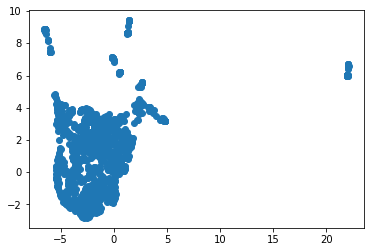

In [9]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=30)
# reducer = TSNE(n_components=2, metric='euclidean')

coords = reducer.fit_transform(mts.features)
plt.scatter(coords[:, 0], coords[:, 1])

In [10]:
from server.source.storage import MTSStorage

# storage = MTSStorage(os.path.join(VIS_PATH ,'ontario_months.npy'))    
storage = MTSStorage(os.path.join(VIS_PATH ,'ontario_days.npy'))    
# storage.delete()
storage.load()

dimensions = pollutans
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    '_'.join(POLLUTANTS) , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        'coords': coords,
    },
    sampling=False,
    n_samples= N_VIZ_SAMPLES
)

storage.save()

mts shape: N: 1381 -  T: 24 - D: 2


In [ ]:
!pwd

/home/texs/Documentos/AirQuality/airqviz
